In [1]:
import numpy as np
import scipy.linalg as la
from scipy.special import factorial
import os,sys,inspect
import h5py
import random as rd
import time
from IPython import display
import matplotlib.pyplot as plt
import re, math
from datetime import datetime

import config

data_path = config.DATA_PATH
file_name = datetime.today().strftime('%h%d')

print("Importing Grape...", flush=True)

from quantum_optimal_control.helper_functions.grape_functions import *
from quantum_optimal_control.main_grape.grape import Grape
from quantum_optimal_control.core import hamiltonian

from fqc import uccsd, util, core
from fqc.models import Pulse

Importing Grape...


In [2]:
d = 2  # this is the number of energy levels to consider (i.e. d-level qudits)
max_iterations = 2000
decay =  max_iterations / 2
convergence = {'rate':0.02, 'max_iterations':max_iterations,
               'conv_target':1e-3, 'learning_rate_decay':decay}
#reg_coeffs = {'amplitude':0.01,'dwdt':0.0001,'d2wdt2':0.00001}
reg_coeffs = {}

----
## H Gate: 2.1ns

In [3]:
N = 1
connected_qubit_pairs = []
H0 = hamiltonian.get_H0(N, d, connected_qubit_pairs)
Hops, Hnames = hamiltonian.get_Hops_and_Hnames(N, d)
states_concerned_list = hamiltonian.get_full_states_concerned_list(N, d)
maxA = hamiltonian.get_maxA(N, d)
U = np.array([[1, 1], [1, -1]]) / math.sqrt(2)
U = transmon_gate(U, d)

In [4]:
total_time = 2.1
steps = int(total_time * 20)
res_h1 = Grape(H0, Hops, Hnames, U, total_time, steps, states_concerned_list, convergence,reg_coeffs=reg_coeffs,use_gpu=False, sparse_H=False, method='ADAM', maxA=maxA,show_plots=False, file_name=file_name, data_path = data_path)

data saved at: /project/ftchong/qoc/yongshan/00033_Feb21.h5
Using 7 Taylor terms and 2 Scaling & Squaring terms
Building graph:
Propagators initialized.
Operators weight initialized.
Intermediate propagation variables initialized.
Intermediate propagators initialized.
Vectors initialized.
Training loss initialized.
Optimizer initialized.
Utilities initialized.
Graph built!
Initialized
Error = :5.08e-01; Runtime: 0.1s; Iterations = 0, grads =   1.107e-02, unitary_metric = 1.00000
Error = :2.52e-02; Runtime: 1.3s; Iterations = 100, grads =   3.671e-04, unitary_metric = 1.00000
Error = :7.22e-03; Runtime: 2.4s; Iterations = 200, grads =   9.508e-05, unitary_metric = 1.00000
Error = :2.15e-03; Runtime: 3.4s; Iterations = 300, grads =   2.026e-05, unitary_metric = 1.00000
Error = :9.99e-04; Runtime: 4.4s; Iterations = 387, grads =   7.886e-06, unitary_metric = 1.00000
data saved at: /project/ftchong/qoc/yongshan/00033_Feb21.h5


---
## Read pulse

In [5]:
fname_h1 = '/project/ftchong/qoc/yongshan/00033_Feb21.h5' #Change this
qubits = [0] # index of qubit the pulse is acting on
pulse_h1= Pulse(N, d, qubits, fname=fname_h1)
res = util.evol_pulse(pulse_h1, save=False)

Using 7 Taylor terms and 2 Scaling & Squaring terms
Building graph:
Propagators initialized.
Operators weight initialized.
Intermediate propagation variables initialized.
Intermediate propagators initialized.
Vectors initialized.
Training loss initialized.
Optimizer initialized.
Utilities initialized.
Graph built!
Initialized
Error = :9.99e-04; Runtime: 0.1s; Iterations = 0, grads =   7.886e-06, unitary_metric = 1.00000


Error: 9.993315e-04


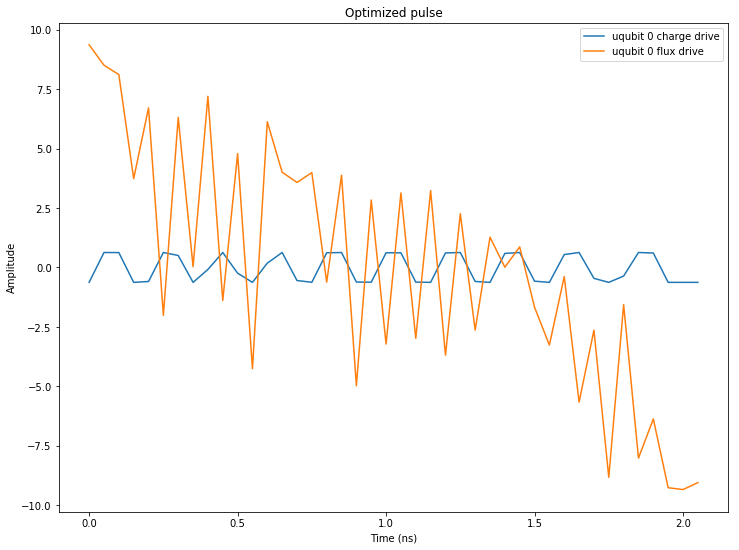

In [6]:
util.plot_pulse(pulse_h1)

In [7]:
res = util.evol_pulse_from_file(fname_h1)

data saved at: /project/ftchong/qoc/yongshan/00034_Feb21.h5
Using 7 Taylor terms and 2 Scaling & Squaring terms
Building graph:
Propagators initialized.
Operators weight initialized.
Intermediate propagation variables initialized.
Intermediate propagators initialized.
Vectors initialized.
Training loss initialized.
Optimizer initialized.
Utilities initialized.
Graph built!
Initialized
Error = :9.99e-04; Runtime: 0.1s; Iterations = 0, grads =   7.886e-06, unitary_metric = 1.00000
data saved at: /project/ftchong/qoc/yongshan/00034_Feb21.h5


Error: 9.993315e-04
Figure saved at: /project/ftchong/qoc/yongshan/h_pulse.pdf


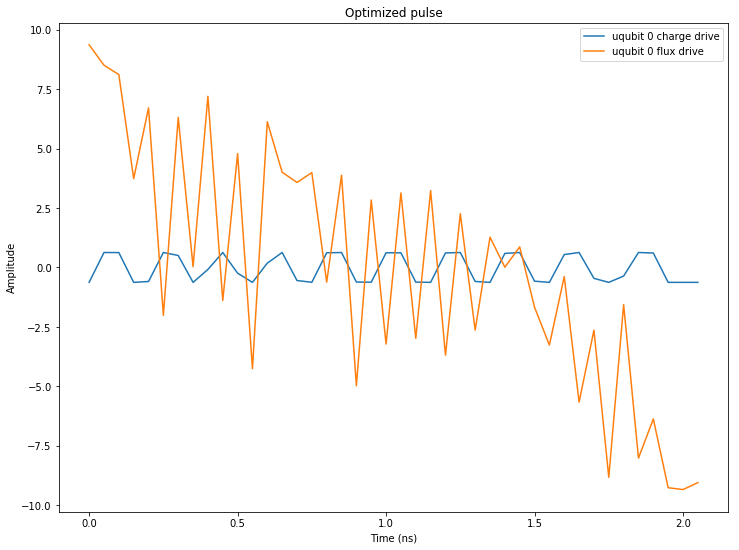

In [8]:
util.plot_pulse_from_file(fname_h1, save_plot=True, file_name='h_pulse')

----
## Improve Pulses
Use 1e-3 pulses as seeds to generate 1e-4 pulses

In [9]:
seeds = [pulse_h1, pulse_h1, pulse_h1]
max_iterations = 2000
decay =  max_iterations / 2
convergence = {'rate':0.02, 'max_iterations':max_iterations,
               'conv_target':1e-4, 'learning_rate_decay':decay}
res_hhh = core.get_opt_pulses(seeds, convergence)

Using 7 Taylor terms and 2 Scaling & Squaring terms
Building graph:
Propagators initialized.
Operators weight initialized.
Intermediate propagation variables initialized.
Intermediate propagators initialized.
Vectors initialized.
Training loss initialized.
Optimizer initialized.
Utilities initialized.
Graph built!
Initialized
Error = :9.99e-04; Runtime: 0.1s; Iterations = 0, grads =   7.886e-06, unitary_metric = 1.00000
Error = :8.95e-03; Runtime: 1.2s; Iterations = 100, grads =   1.022e-04, unitary_metric = 1.00000
Error = :2.79e-03; Runtime: 2.3s; Iterations = 200, grads =   1.469e-05, unitary_metric = 1.00000
Error = :4.10e-03; Runtime: 3.4s; Iterations = 300, grads =   6.090e-06, unitary_metric = 1.00000
Error = :1.27e-02; Runtime: 4.5s; Iterations = 400, grads =   5.762e-05, unitary_metric = 1.00000
Error = :3.90e-03; Runtime: 5.6s; Iterations = 500, grads =   3.158e-06, unitary_metric = 1.00000
Error = :5.78e-03; Runtime: 6.7s; Iterations = 600, grads =   7.124e-06, unitary_metri

----
## Concatenate Pulses

In [10]:
hh = [pulse_h1, pulse_h1]
Iden = np.eye(2**N)
Iden = transmon_gate(Iden, d)
converge = {}
res_hh = core.concat_and_evol(N, d, hh, Iden)

data saved at: /project/ftchong/qoc/yongshan/00035_Feb21.h5
Using 7 Taylor terms and 2 Scaling & Squaring terms
Building graph:
Propagators initialized.
Operators weight initialized.
Intermediate propagation variables initialized.
Intermediate propagators initialized.
Vectors initialized.
Training loss initialized.
Optimizer initialized.
Utilities initialized.
Graph built!
Initialized
Error = :1.90e-05; Runtime: 0.2s; Iterations = 0, grads =   6.748e-05, unitary_metric = 1.00000
data saved at: /project/ftchong/qoc/yongshan/00035_Feb21.h5


Error: 2.741814e-05
Figure saved at: /project/ftchong/qoc/yongshan/hh_pulse.pdf


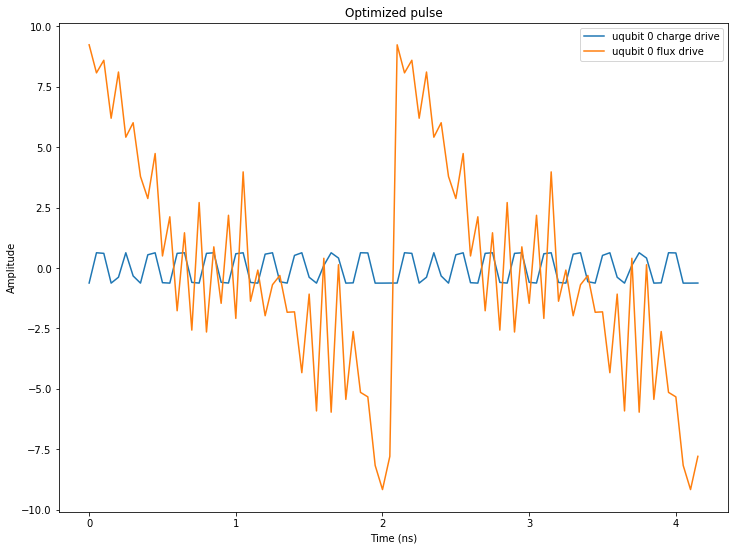

In [11]:
fname_hh = '/project/ftchong/qoc/yongshan/00026_Feb21.h5' # Change me
util.plot_pulse_from_file(fname_hh, save_plot=True, file_name='hh_pulse')

---
## RX(Θ) Gate: 4.2 ns (at most)
For this one, the longest time is for theta = pi, as expected.

In [12]:
N = 1
connected_qubit_pairs = []
H0 = hamiltonian.get_H0(N, d, connected_qubit_pairs)
Hops, Hnames = hamiltonian.get_Hops_and_Hnames(N, d)
states_concerned_list = hamiltonian.get_full_states_concerned_list(N, d)
maxA = hamiltonian.get_maxA(N, d)
theta = np.random.rand() * np.pi
print("Random angle (radian): " + str(theta))
U = np.array([[np.cos(theta / 2.0), np.sin(theta / 2.0) * -1j], [np.sin(theta / 2.0) * -1j, np.cos(theta / 2.0)]])
U = transmon_gate(U, d)
reg_coeffs = {}

Random angle (radian): 1.4830495879928982


In [13]:
total_time = 4.2
steps = int(total_time * 20)
res_rx1 = Grape(H0, Hops, Hnames, U, total_time, steps, states_concerned_list, convergence,reg_coeffs=reg_coeffs,use_gpu=False, sparse_H=False, method='ADAM', maxA=maxA,show_plots=False, file_name=file_name, data_path = data_path)

data saved at: /project/ftchong/qoc/yongshan/00036_Feb21.h5
Using 7 Taylor terms and 2 Scaling & Squaring terms
Building graph:
Propagators initialized.
Operators weight initialized.
Intermediate propagation variables initialized.
Intermediate propagators initialized.
Vectors initialized.
Training loss initialized.
Optimizer initialized.
Utilities initialized.
Graph built!
Initialized
Error = :4.45e-01; Runtime: 0.1s; Iterations = 0, grads =   2.079e-02, unitary_metric = 0.99999
Error = :9.76e-05; Runtime: 2.3s; Iterations = 85, grads =   1.346e-05, unitary_metric = 1.00000
data saved at: /project/ftchong/qoc/yongshan/00036_Feb21.h5


---
### Build seeds

In [18]:
fname_rx = '/project/ftchong/qoc/yongshan/00036_Feb21.h5' #Change this
qubits = [0] # index of qubit the pulse is acting on
# First Angle
theta1 = np.random.rand() * np.pi
print("Random angle (radian): " + str(theta1))
U1 = np.array([[np.cos(theta1 / 2.0), np.sin(theta1 / 2.0) * -1j], [np.sin(theta1 / 2.0) * -1j, np.cos(theta1 / 2.0)]])
U1 = transmon_gate(U1, d)
seed1 = Pulse(N, d, qubits, fname=fname_rx)
seed1.set_params(U=U1)
# Second Angle
theta2 = np.random.rand() * np.pi
print("Random angle (radian): " + str(theta2))
U2 = np.array([[np.cos(theta2 / 2.0), np.sin(theta2 / 2.0) * -1j], [np.sin(theta2 / 2.0) * -1j, np.cos(theta2 / 2.0)]])
U2 = transmon_gate(U2, d)
seed2 = Pulse(N, d, qubits, fname=fname_rx)
seed2.set_params(U=U2)

Random angle (radian): 1.276630202798835
Random angle (radian): 0.28646029804746426


### Using seeds

In [19]:
seeds = [seed1, seed2]
max_iterations = 2000
decay =  max_iterations / 2
convergence = {'rate':0.02, 'max_iterations':max_iterations,
               'conv_target':1e-3, 'learning_rate_decay':decay}
res_rxrx = core.get_opt_pulses(seeds, convergence)

Using 7 Taylor terms and 2 Scaling & Squaring terms
Building graph:
Propagators initialized.
Operators weight initialized.
Intermediate propagation variables initialized.
Intermediate propagators initialized.
Vectors initialized.
Training loss initialized.
Optimizer initialized.
Utilities initialized.
Graph built!
Initialized
Error = :1.26e-02; Runtime: 0.1s; Iterations = 0, grads =   1.433e-03, unitary_metric = 1.00000
Error = :2.10e-04; Runtime: 0.7s; Iterations = 18, grads =   3.214e-04, unitary_metric = 1.00000
Using 7 Taylor terms and 2 Scaling & Squaring terms
Building graph:
Propagators initialized.
Operators weight initialized.
Intermediate propagation variables initialized.
Intermediate propagators initialized.
Vectors initialized.
Training loss initialized.
Optimizer initialized.
Utilities initialized.
Graph built!
Initialized
Error = :3.26e-01; Runtime: 0.1s; Iterations = 0, grads =   2.873e-02, unitary_metric = 1.00000
Error = :6.17e-04; Runtime: 1.6s; Iterations = 60, grad